In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Conv2DTranspose, Dropout
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, Layer
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model
from google.colab import drive
import tensorflow as tf
import numpy as np
import datetime
import warnings
import os

drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
class Incremento(Layer):
    def __init__(self, filtros, kernel_size= 3):
        super(Incremento, self).__init__()
        self.conv1= Conv2D(filtros, kernel_size= kernel_size, padding= "same", activation="relu")
        self.conv2= Conv2D(filtros, kernel_size= kernel_size, padding= "same", activation="relu")
        self.maxpool= MaxPooling2D(3, strides= 2, padding= "same")
        self.bn1= BatchNormalization()
        self.bn2= BatchNormalization()

    def call(self, input_tensor):
        x= self.conv1(input_tensor)        
        x= self.bn1(x)
        x= self.conv2(x)
        x= self.bn2(x)
        resdual= x
        x= self.maxpool(x)
        
        return resdual, x



class Cuello_botella(Layer):
    def __init__(self, filtros_conv, filtros_transpose, kernel_size= 3):
        super(Cuello_botella, self).__init__()
        self.conv1= Conv2D(filtros_conv, kernel_size= kernel_size, padding= "same", activation="relu")
        self.conv2= Conv2D(filtros_conv, kernel_size= kernel_size, padding= "same", activation="relu")
        self.convT= Conv2DTranspose(filtros_transpose, kernel_size= kernel_size, padding= "same", activation= "relu")
        self.bn1= BatchNormalization()
        self.bn2= BatchNormalization()

    def call(self, input_tensor):
        x= self.conv1(input_tensor)
        x= self.bn1(x)
        x= self.conv2(x)
        x= self.bn2(x)
        return self.convT(x)



class Decremento(Layer):
    def __init__(self, filtros, kernel_size= 3):
        super(Decremento, self).__init__()
        self.conv1= Conv2D(filtros, kernel_size= kernel_size, padding= "same", activation="relu")
        self.conv2= Conv2D(filtros, kernel_size= kernel_size, padding= "same", activation="relu")
        self.convT= Conv2DTranspose(int(filtros/2), kernel_size= kernel_size, padding= "same")
        self.bn1= BatchNormalization()
        self.bn2= BatchNormalization()
    
    def call(self, input_tensor):
        x= self.conv1(input_tensor)
        x= self.bn1(x)
        x= self.conv2(x)
        x= self.bn2(x)
        return self.convT(x)




class Crop_and_cat(Layer):
    def __init__(self):
        super(Crop_and_cat, self).__init__()
        self.Upsam= UpSampling2D(2)

    def call(self, input_tensor, res):
        x= self.Upsam(input_tensor)
        return concatenate([x, res])





class Capa_final(Layer):
    def __init__(self, filtros, num_clases, kernel_size= 3):
        super(Capa_final, self).__init__()

        self.conv1= Conv2D(filtros, kernel_size= kernel_size, padding= "same", activation="relu")
        self.conv2= Conv2D(filtros, kernel_size= kernel_size, padding= "same", activation="relu")
        self.conv_f= Conv2D(num_clases, kernel_size= kernel_size, padding= "same", activation="softmax")
        self.bn1= BatchNormalization()
        self.bn2= BatchNormalization()

    def call(self, input_tensor):
        x= self.conv1(input_tensor)
        x= self.bn1(x)
        x= self.conv2(x)
        x= self.bn2(x)
        x= self.conv_f(x)
        return x

In [ ]:
class UNET(Model):
  def __init__(self, num_clases):
    super(UNET, self).__init__()

    self.convi_1= Incremento(64)
    self.convi_2= Incremento(128)
    self.convi_3= Incremento(256)

    self.bot= Cuello_botella(512, 256)

    self.crop1= Crop_and_cat()
    self.crop2= Crop_and_cat()
    self.crop3= Crop_and_cat()


    self.dec1= Decremento(256)
    self.dec2= Decremento(128)

    self.salida= Capa_final(64, num_clases)
    #self.drop= Dropout(rate= 0.5)


  def call(self, entrada_tam):

    res1, x= self.convi_1(entrada_tam)
    res2, x= self.convi_2(x)
    res3, x= self.convi_3(x)
    x= self.bot(x)
    x= self.crop1(x, res3)
    x= self.dec1(x)
    x= self.crop2(x, res2)
    x= self.dec2(x)
    x= self.crop3(x, res1) 
    x= self.salida(x)
    #x= self.drop(x)

    return x

  def build_graph(self, raw_shape):
    x= tf.keras.layers.Input(shape= raw_shape)
    return tf.keras.Model(inputs=[x], outputs= self.call(x))

In [ ]:
raw_input = (320, 320, 3)

mi_modelo = UNET(2)
y = mi_modelo(tf.ones(shape=(0,*raw_input)))

mi_modelo.build_graph(raw_input).summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 incremento_3 (Incremento)      ((None, 320, 320, 6  39232       ['input_2[0][0]']                
                                4),                                                               
                                 (None, 160, 160, 6                                               
                                4))                                                               
                                                                                            

In [ ]:
!unzip "/content/drive/MyDrive/Proyectos/Kika/Base de datos/Ent.zip" -d "/content/sample_data/"
!unzip "/content/drive/MyDrive/Proyectos/Kika/Base de datos/Val.zip" -d "/content/sample_data/"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/sample_data/Ent/mask_patches/8940.png  
  inflating: /content/sample_data/Ent/mask_patches/8941.png  
  inflating: /content/sample_data/Ent/mask_patches/8942.png  
  inflating: /content/sample_data/Ent/mask_patches/8943.png  
  inflating: /content/sample_data/Ent/mask_patches/8944.png  
  inflating: /content/sample_data/Ent/mask_patches/8945.png  
  inflating: /content/sample_data/Ent/mask_patches/8946.png  
  inflating: /content/sample_data/Ent/mask_patches/8947.png  
  inflating: /content/sample_data/Ent/mask_patches/8948.png  
  inflating: /content/sample_data/Ent/mask_patches/8949.png  
  inflating: /content/sample_data/Ent/mask_patches/895.png  
  inflating: /content/sample_data/Ent/mask_patches/8950.png  
  inflating: /content/sample_data/Ent/mask_patches/8951.png  
  inflating: /content/sample_data/Ent/mask_patches/8952.png  
  inflating: /content/sample_data/Ent/mask_patches/8953.png  
  inflatin

In [ ]:
ent_input_dir= "/content/sample_data/Ent/img_patches"
ent_target_dir= "/content/sample_data/Ent/mask_patches"

val_input_dir= "/content/sample_data/Val/img_patches"
val_target_dir= "/content/sample_data/Val/mask_patches"

input_img_paths = sorted(
    [
        os.path.join(ent_input_dir, fname)
        for fname in os.listdir(ent_input_dir) 
        if fname.endswith(".png")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(ent_target_dir, fname)
        for fname in os.listdir(ent_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_input_paths = sorted(
    [
        os.path.join(val_input_dir, fname)
        for fname in os.listdir(val_input_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_target_paths = sorted(
    [
        os.path.join(val_target_dir, fname)
        for fname in os.listdir(val_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

no_ent= len(input_img_paths)
no_val= len(val_target_paths)

In [ ]:
class MiClasificacion():
    def __init__(self, No_img, cont= 0, batch_size= 32, img_size= (304, 304)):
        self.batch_size= batch_size
        self.img_size= img_size
        self.cont= cont
        self.steps= No_img// self.batch_size
        self.ID_input= np.arange(No_img)

    def dar_datos(self, img_dir, val_dir):
        if self.steps== self.cont or self.cont== 0:
            np.random.shuffle(self.ID_input)
            self.cont= 0
        
        batch_img= []
        batch_tar= []
        i= self.cont* self.batch_size
        self.cont+= 1

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8") 


        for ig in self.ID_input[i : i + self.batch_size]:
            batch_img.append(img_dir[ig])
            batch_tar.append(val_dir[ig])


        for j, path in enumerate(batch_img):
                img = load_img(path, target_size= self.img_size)
                x[j] = np.array(img)/255.0  

        for j, path in enumerate(batch_tar):
                img = load_img(path,target_size= self.img_size, color_mode="grayscale")
                y[j] = np.expand_dims(img, 2)
                
                for r in range(y.shape[1]):
                    for g in range(y.shape[2]):
                        if y[j, r, g, 0]!= 0:
                            y[j, r, g, 0]= 1
    
        return x, y

In [ ]:
img_size = (320, 320)
num_classes = 2; batch_size_t = 16; batch_size_v = 16

train_gen = MiClasificacion(no_ent, batch_size= batch_size_t, img_size= img_size)
val_gen = MiClasificacion(no_val, batch_size=batch_size_v, img_size= img_size)

In [ ]:
optimizer= tf.keras.optimizers.Adam()
loss_fn= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False)

train_loss= tf.keras.metrics.Mean(name= 'train_loss')
train_accuracy= tf.keras.metrics.SparseCategoricalAccuracy(name= 'train_accuracy')
train_recall= tf.keras.metrics.Recall(name= 'train_recall')
train_precision= tf.keras.metrics.Precision(name= 'train_precision')


test_loss= tf.keras.metrics.Mean(name= 'test_loss')
test_accuracy= tf.keras.metrics.SparseCategoricalAccuracy(name= 'test_accuracy')
test_recall= tf.keras.metrics.Recall(name= 'test_recall')
test_precision= tf.keras.metrics.Precision(name= 'test_precision')


current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = '/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Metricas/' + current_time + '/train'
test_log_dir = '/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Metricas/' + current_time + '/test'

train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [ ]:
@tf.function
def train_step(x, y, y_n):
    
    with tf.GradientTape() as tape:
        predict= mi_modelo(x, training= True)
        loss= loss_fn(y, predict)

    grads= tape.gradient(loss, mi_modelo.trainable_variables)
    optimizer.apply_gradients(zip(grads, mi_modelo.trainable_variables))

    train_loss(loss)
    train_accuracy(y, predict)
    train_recall(y_n, predict)
    train_precision(y_n, predict)

@tf.function
def test_step(x, y, y_n):
    
    predictions= mi_modelo(x, training= False)
    loss= loss_fn(y, predictions)

    test_loss(loss)
    test_accuracy(y, predictions)
    test_recall(y_n, predictions)
    test_precision(y_n, predictions)

In [ ]:
epocas= 150
loss_best= 1500

for epoca in range(epocas):
  train_loss.reset_states()
  train_accuracy.reset_states()
  train_recall.reset_states()
  train_precision.reset_states()

  test_loss.reset_state()
  test_accuracy.reset_state()
  test_recall.reset_states()
  test_precision.reset_states()

  for t in range(int(no_ent/batch_size_t)):
    images, labels= train_gen.dar_datos(input_img_paths, target_img_paths)
    y= tf.keras.utils.to_categorical(labels, num_classes= 2)
    train_step(images, labels, y)
  with train_summary_writer.as_default():
    tf.summary.scalar('Loss', train_loss.result(), step=epoca)
    tf.summary.scalar('Accuracy', train_accuracy.result(), step=epoca)
    tf.summary.scalar('Recall', train_recall.result(), step=epoca)
    tf.summary.scalar('Presicion', train_precision.result(), step=epoca)        

  for t in range(int(no_val/batch_size_t)):
    test_im, test_label= val_gen.dar_datos(val_input_paths, val_target_paths)
    y= tf.keras.utils.to_categorical(test_label, num_classes= 2)
    test_step(test_im, test_label, y)
  with test_summary_writer.as_default():
    tf.summary.scalar('Loss_t', test_loss.result(), step=epoca)
    tf.summary.scalar('Accuracy_t', test_accuracy.result(), step=epoca)
    tf.summary.scalar('Recall_t', test_recall.result(), step=epoca)
    tf.summary.scalar('Presicion_t', test_precision.result(), step=epoca) 
  
  if test_loss.result() < loss_best:
    loss_best= test_loss.result()/1
    mi_modelo.save_weights('/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet')
    mi_modelo.save('/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py')

  print('-------------------------------------------------\n')
  print(
      f'Epoca {epoca+ 1}, '
      f'Loss: {train_loss.result():.3f}, '
      f'Accuracy: {train_accuracy.result()* 100:.3f}, '
      f'Recall: {train_recall.result()* 100:.3f}, '
      f'Precision: {train_precision.result()* 100:.3f} '
      )
      
  print(
      f'Loss_test: {test_loss.result():.3f}, '
      f'Accuracy_test: {test_accuracy.result()* 100:.3f}, '
      f'Recall_test: {test_recall.result()* 100:.3f}, '
      f'Precision_test: {test_precision.result()* 100:.3f} '
  )
  print('\n-------------------------------------------------')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


-------------------------------------------------

Epoca 1, Loss: 0.132, Accuracy: 95.643, Recall: 95.643, Precision: 95.643 
Loss_test: 0.147, Accuracy_test: 94.487, Recall_test: 94.487, Precision_test: 94.487 

-------------------------------------------------
-------------------------------------------------

Epoca 2, Loss: 0.088, Accuracy: 96.674, Recall: 96.674, Precision: 96.674 
Loss_test: 1.974, Accuracy_test: 30.418, Recall_test: 30.418, Precision_test: 30.418 

-------------------------------------------------


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


-------------------------------------------------

Epoca 3, Loss: 0.082, Accuracy: 96.808, Recall: 96.808, Precision: 96.808 
Loss_test: 0.096, Accuracy_test: 96.439, Recall_test: 96.439, Precision_test: 96.439 

-------------------------------------------------


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


-------------------------------------------------

Epoca 4, Loss: 0.077, Accuracy: 96.974, Recall: 96.974, Precision: 96.974 
Loss_test: 0.073, Accuracy_test: 97.100, Recall_test: 97.100, Precision_test: 97.100 

-------------------------------------------------
-------------------------------------------------

Epoca 5, Loss: 0.075, Accuracy: 97.016, Recall: 97.016, Precision: 97.016 
Loss_test: 0.089, Accuracy_test: 96.604, Recall_test: 96.604, Precision_test: 96.604 

-------------------------------------------------
-------------------------------------------------

Epoca 6, Loss: 0.073, Accuracy: 97.071, Recall: 97.071, Precision: 97.071 
Loss_test: 0.090, Accuracy_test: 96.735, Recall_test: 96.735, Precision_test: 96.735 

-------------------------------------------------


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


-------------------------------------------------

Epoca 7, Loss: 0.072, Accuracy: 97.105, Recall: 97.105, Precision: 97.105 
Loss_test: 0.072, Accuracy_test: 97.166, Recall_test: 97.166, Precision_test: 97.166 

-------------------------------------------------


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


-------------------------------------------------

Epoca 8, Loss: 0.071, Accuracy: 97.140, Recall: 97.140, Precision: 97.140 
Loss_test: 0.070, Accuracy_test: 97.211, Recall_test: 97.211, Precision_test: 97.211 

-------------------------------------------------


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


-------------------------------------------------

Epoca 9, Loss: 0.069, Accuracy: 97.181, Recall: 97.181, Precision: 97.181 
Loss_test: 0.070, Accuracy_test: 97.206, Recall_test: 97.206, Precision_test: 97.206 

-------------------------------------------------
-------------------------------------------------

Epoca 10, Loss: 0.068, Accuracy: 97.215, Recall: 97.215, Precision: 97.215 
Loss_test: 0.072, Accuracy_test: 97.099, Recall_test: 97.099, Precision_test: 97.099 

-------------------------------------------------


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py/assets


-------------------------------------------------

Epoca 11, Loss: 0.067, Accuracy: 97.242, Recall: 97.242, Precision: 97.242 
Loss_test: 0.069, Accuracy_test: 97.206, Recall_test: 97.206, Precision_test: 97.206 

-------------------------------------------------
-------------------------------------------------

Epoca 12, Loss: 0.066, Accuracy: 97.280, Recall: 97.280, Precision: 97.280 
Loss_test: 0.075, Accuracy_test: 97.207, Recall_test: 97.207, Precision_test: 97.207 

-------------------------------------------------
-------------------------------------------------

Epoca 13, Loss: 0.065, Accuracy: 97.296, Recall: 97.296, Precision: 97.296 
Loss_test: 0.070, Accuracy_test: 97.183, Recall_test: 97.183, Precision_test: 97.183 

-------------------------------------------------
-------------------------------------------------

Epoca 14, Loss: 0.064, Accuracy: 97.343, Recall: 97.343, Precision: 97.343 
Loss_test: 0.073, Accuracy_test: 97.106, Recall_test: 97.106, Precision_test: 97.

In [1]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from google.colab import drive
from PIL import ImageOps
import tensorflow as tf
import numpy as np
import cv2 as cv
import PIL


drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DIR= '/content/drive/MyDrive/Proyectos/Kika/MetricasModelos/Modelos/Unet/Unet.h5py'
model= tf.keras.models.load_model(DIR)

In [7]:
def cambio_tam(img, msk):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    gray = cv.GaussianBlur(gray, (7, 7), 3)
    t, dst = cv.threshold(gray, 0, 255, cv.THRESH_BINARY | cv.THRESH_TRIANGLE)
    contours, _= cv.findContours(dst, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    a = []

    for c in contours:
        area = cv.contourArea(c)
        a.append(area)
        
    for f in contours:
        area = cv.contourArea(f)
        if area == max(a):
            x, y, w, h = cv.boundingRect(f)
            imgr = img[y:y + h, x:x + w]
            mask = msk[y:y + h, x:x + w]

    return imgr, mask

def equalize_clahe_color(img):
    cla = cv.createCLAHE(clipLimit=1.5)     
    channels = cv.split(img)     
    eq_channels = []
    for ch in channels:         
        eq_channels.append(cla.apply(ch))     
        eq_image = cv.merge(eq_channels)     
    return eq_image

def pre_procesamiento(img):
    return cv.cvtColor(equalize_clahe_color(cv.cvtColor(img, cv.COLOR_BGR2RGB)), cv.COLOR_BGR2RGB)

def prediccion_m(model, img):
  img= (np.array(img).reshape(-1,320,320,3))/255.0
  val_preds = model.predict(img)
  mask = np.argmax(val_preds[0], axis=-1)
  mask = np.expand_dims(mask, axis=-1)
  img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
  
  return np.array(img)

# Genera los patches de entrada para el modelo
def generar_patch(img, tam= 320):
    f= []; g= 0; c= 0
    for t in range(int(img.shape[0]/tam)):
        for j in range(int(img.shape[1]/tam)):
            f.append(img[g:g+ tam, c: c+ tam, :])
            c+= tam
        if img.shape[1]% tam != 0:
            f.append(cv.resize(img[g:g+ tam, c: c+ (img.shape[1]-c), :], (tam, tam), interpolation = cv.INTER_AREA))
        g+= tam; c= 0
        
    for t in range(int(img.shape[1]/tam)):
        f.append(cv.resize(img[g:g+ (img.shape[0]- g), c: c+ tam, :], (tam, tam), interpolation = cv.INTER_AREA))
        c+= tam
    if img.shape[1]% tam != 0:
        f.append(cv.resize(img[g:g+ (img.shape[0]-g), c: c+ (img.shape[1]-c), :], (tam,tam), interpolation = cv.INTER_AREA))
    
    return f

def construccion_img(img, model, f, n= 0, c= 0, g= 0, tam= 320):
    img_pred= np.zeros((img.shape[0], img.shape[1]))
    for t in range(int(img.shape[0]/tam)):
        for j in range(int(img.shape[1]/tam)):
            p= prediccion_m(model, f[n])
            img_pred[g: g+ tam, c: c+ tam]= p
            c+= tam; n+= 1
        if img.shape[1]% tam != 0:
            p= cv.resize(prediccion_m(model, f[n]), (img.shape[1]-c, tam), interpolation = cv.INTER_AREA)
            img_pred[g: g+ tam, c:]= p
        g+= tam; c= 0; n+= 1
        
    for t in range(int(img.shape[1]/tam)):
        p= cv.resize(prediccion_m(model, f[n]), (tam, img.shape[0]-g), interpolation = cv.INTER_AREA)
        img_pred[g:, c: c+ tam]= p
        c+= tam; n+= 1
    if img.shape[1]% tam != 0:
        p= cv.resize(prediccion_m(model, f[n]), (img.shape[1]-c, img.shape[0]-g), interpolation = cv.INTER_AREA)
        img_pred[g:, c:]= p
    
    return img_pred

def imagenes_comp(img, mask, s1= None, s2= None, s3= None, mostrar= False, guardar= False):
  img_t= np.zeros((img.shape[0], img.shape[1], 3), dtype= np.float)
  conv= np.zeros((img.shape[0], img.shape[1], 3), dtype= np.float)
  img_t[:, :, 1]= img

  conv[:,:,0]= mask[:,:,0]
  conv[:,:,1]= img

  if mostrar== True:
    plt.imshow(img_t, cmap= 'gray')
    plt.show()

    plt.imshow(mask, cmap= 'gray')
    plt.show()

    plt.imshow(conv)
    plt.show()
  
  if guardar== True:
    plt.imsave(s1, img_t/255.0)
    plt.imsave(s2, mask/255.0)
    plt.imsave(s3, conv/255.0)


def prediccion_final(model, DIR, DIR_M):
  img= cv.imread(DIR)
  mask= tf.keras.preprocessing.image.load_img(DIR_M)
  mask= tf.keras.preprocessing.image.img_to_array(mask)

  img, msk= cambio_tam(img, mask)
  img= equalize_clahe_color(img)

  f= generar_patch(img)
  pred= construccion_img(img, model, f)

  return pred, msk

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


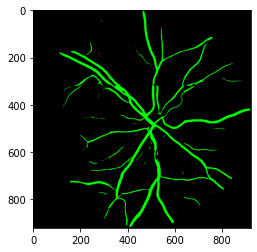

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


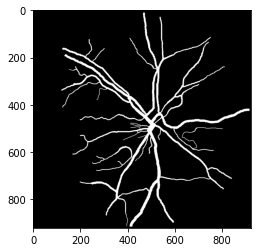

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


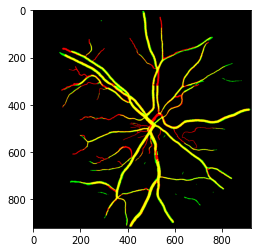

In [8]:
DIR= "/content/drive/MyDrive/Proyectos/Kika/Base de datos/Pruebas/Image_14R.jpg"
DIR_M= "/content/drive/MyDrive/Proyectos/Kika/Base de datos/Pruebas/Image_14R_1stHO.png"

s1= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/Hemorragias/com/p_vgg.png"
s2= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/Hemorragias/com/m_vgg.png"
s3= "/content/drive/MyDrive/Proyectos/Sharon/Base de datos/Pruebas/Hemorragias/com/conv_vggm.png"

pred, mask= prediccion_final(model, DIR, DIR_M)

imagenes_comp(pred, mask, s1, s2, s3, True, False)